# 创建合成数据
可用的真实地图数量很少(最多1000个示例)。为了克服这一困难，利用模拟数据对卷积神经网络进行训练和验证。

## 导入模块

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
%matplotlib inline

import os
from sklearn.utils import shuffle 
import random
from skimage import draw
import pandas as pd
from scipy import ndimage
import cv2 

from PIL import Image

import seaborn as sns
sns.set()

from tqdm import tqdm

#%matplotlib notebook
np.set_printoptions(suppress=True)  # 禁止打印多余信息

In [2]:
os.getcwd()

'/home/jiajianhao/文档/cnn/Magnetic_methods-master/YOLO/Synthetic_data'

In [3]:
# from My_Utils import * # all the functions created that will be useful
# all the functions created that will be useful
from My_Utils_Magnetic_methods import *
from My_Utils import *
# 设置画图语言为雅黑体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False

##  Model


### Model Griding
这段代码创建了一个网格，其中 'zmax' 表示总的网格线数，'map_lenght' 表示地图的长度，以米为单位。然后使用自建的工具模块 `grid` 函数生成 X 和 Y 的坐标(x,y都是-25到25,共100个值)


In [4]:
grid_caracteristic = {

    'zmax': 100,  # Total number of grid lines
    # [m] Our grid will be between (-map_lenght,map_lenght) because our anomalie is centered in (0,0)
    'map_lenght': 25
}  # 网格属性

zmax = grid_caracteristic['zmax']
map_lenght = grid_caracteristic['map_lenght']

X, Y = grid(zmax, map_lenght)  # X and Y in [meters]

print(f'X array shape: {X.shape}')
print(f'Y array shape: {Y.shape}')
print(f'Cell lenght: {(map_lenght*2)/zmax}')

X array shape: (100, 1)
Y array shape: (1, 100)
Cell lenght: 0.5



### Latitudes



使用 `latitudes_array` 函数生成相应的纬度数组（以度和弧度表示），以及倾斜角（Inclination）的数组。


In [5]:
lat_dict = {

    'lat_min': 0,  # [°]
    'lat_max': 120,  # [°]
    'lat_frequency': 30,  # [°]

}

lat_array, lat_array_rad, I = latitudes_array(
    lat_dict['lat_min'], lat_dict['lat_max'], lat_dict['lat_frequency'])

print(f'Latitudes: {lat_array} [°]')  # °
print(f'Latitudes: {np.round(lat_array_rad, decimals=2)} [rad]')  # 弧度制
print(f'Inclinaison: {np.round(I, decimals=2)} [rad]')  # 倾角

Latitudes: [ 0 30 60 90] [°]
Latitudes: [0.   0.52 1.05 1.57] [rad]
Inclinaison: [0.   0.86 1.29 1.57] [rad]



## Defining anomalies physical characteristics



这段代码定义了一些物理参数

In [6]:
r_v_d_dict = {

    'Br': 47000,  # Champ local(nT)
    'r_min': 0.05,  # [meters]
    'r_max': 0.09,  # [meters]
    'eAboughtLAndR': 4,
    'r_frequency': 0.01,  # [meters]
    'h_min': 1.0,  # [meters]
    'h_max': 1.8,  # [meters]
    'h_frequency': 0.2,  # [meters]


}

Br = r_v_d_dict['Br']
r_min = r_v_d_dict['r_min']
r_max = r_v_d_dict['r_max']
eAboughtLAndR = r_v_d_dict['eAboughtLAndR']
r_frequency = r_v_d_dict['r_frequency']
h_min = r_v_d_dict['h_min']
h_max = r_v_d_dict['h_max']
h_frequency = r_v_d_dict['h_frequency']
# position = np.array(
#     np.mat('0 0 0;60 0 0'))
# position = np.array(
#     np.mat('0 0 0;30 0 0;60 0 0;60 180 0;60 270 0;90 0 60;90 0 180;0 120 0;0 90 0'))
theta_range = [0]
theta_frequency = 30
phi_range = [0,90,120,180]
phi_frequency = 90
gama_range = [0,60,120,180]
r_array = np.arange(r_min, r_max, r_frequency)
numberOfPosition = len(theta_range)*len(phi_range)*len(gama_range)
position = np.zeros((numberOfPosition,3))
count = 0
for theta in theta_range:
    for phi in phi_range:
        for gama in gama_range:
            position[count,:] = gama,theta,phi
            count+=1


r_array, V_array, h_array, n_examples, Parameters_array = r_V_h_array(r_min, r_max, r_frequency, eAboughtLAndR,
                                                                      h_min, h_max, h_frequency, position,
                                                                      zmax, Br)
L_array = eAboughtLAndR*r_array

# Last 3 examples
print(f'Radius: {np.round(r_array[:], decimals=3)} [meters]')
print(f'Volume: {V_array[:]} [m^3]')  # Last 3 examples
print(f'Number of V: {V_array.shape[0]}')  # Last 3 examples
print("---------------------------------------------")
# Last 3 examples
print(f'Depth: {np.round(h_array[:], decimals = 2)} [meters]')
print(f'Number of h: {h_array.shape[0]}')  # Last 3 examples
print("---------------------------------------------")
print(f'Number of examples: {n_examples}')
print(f'Parameters array shape: {Parameters_array.shape} ')

Radius: [0.05 0.06 0.07 0.08] [meters]
Volume: [0.002 0.004 0.006 0.009] [m^3]
Number of V: 4
---------------------------------------------
Depth: [1.  1.2 1.4 1.6] [meters]
Number of h: 4
---------------------------------------------
Number of examples: 256
Parameters array shape: (256, 5) 


<a name='4'></a>
## 4.  Creating X and Y array 

<a name='4.1'></a>
### 4.1 Raw data (before data augmetation在数据增强之前)



这个函数似乎用于计算垂直方向上的磁感应强度。它通过对每个经度的不同纬度值进行迭代，计算在每个网格点上的磁感应强度。

函数的输入包括磁场强度（'Br'）、磁矩（'m'）、倾斜角（'I'）、X、Y、深度（'h'）、传感器的底部和顶部高度（'H_capteur_bas'和'H_capteur_haut'）、纬度数量（'N_lat'）、示例数量（'examples'）、网格数量（'zmax'）、参数数量（'n_parameters'）、以及纬度的弧度表示和参数数组。

该函数的输出包括一个包含磁感应强度值的三维数组（'X_array_raw'）和一个包含体积和深度值的三维数组（'Parameters_array_raw'）。


In [7]:
# Capteur type fluxgate, on calcule la composante verticale

def X_array_raw(map_lenght, eAboughtLAndR,N_lat, examples,
                zmax, n_parameters, lat_array, Parameters_array):

    X_array_raw = np.zeros((N_lat, examples, zmax, zmax))  # 初始化磁感应值数组
    Parameters_array_raw = np.zeros((N_lat, examples, n_parameters))  # 初始化参数数组


    i = 0

    for i_lat in lat_array:  # 遍历纬度弧度
        Parameters_array_raw[i, :, :] = Parameters_array[:, :]
        for i_example in range(examples):
            r = round(Parameters_array[i_example,0],2)
            L = round(eAboughtLAndR * r,2)
            z = round(Parameters_array[i_example,1],2)
            gama,theta,phi = Parameters_array[i_example,2:]
            print(i_lat,i_example,r,L,z,gama,theta,phi)
            # X_array_raw[i,i_example, :, :] = MyModel().F
            X_array_raw[i,i_example, :, :] = MyModel(map_lenght, zmax, L, r,r ,gama,theta,phi,0,0,z=z,I=i_lat,D=0).F
        i =i + 1

    return X_array_raw, Parameters_array_raw

In [8]:
### X_data array, Calculating Induction magnétique de l'Anomalie [nT] ###

X_Y_array_dict = {
    'N_latitudes': lat_array.shape[0],  # Number of latitudes
    'N_parameters': Parameters_array.shape[1]  # Number of parameters
}

N_latitudes = X_Y_array_dict["N_latitudes"]
N_parameters = X_Y_array_dict["N_parameters"]

In [9]:
# X_data_array_raw, Parameters_array_raw = X_array_raw(map_lenght,eAboughtLAndR , N_latitudes,
#                                                      n_examples, zmax, N_parameters,
#                                                      lat_array, Parameters_array)

# print(f'X array raw shape: {X_data_array_raw.shape}')
# print(f'Parameters array raw shape: {Parameters_array_raw.shape}')
# # 存储
# np.save(file="./data/X_data_array_raw768.npy", arr=X_data_array_raw)
# np.save(file="./data/Parameters_array_raw768.npy", arr=Parameters_array_raw)

In [10]:
theta_range1 = [0]
for theta_range_num in theta_range1:
    X_data_array_raw = np.load(
        file="./X_data_array_raw768_"+str(theta_range_num)+".npy")
    Parameters_array_1 = np.load(
        file="./Parameters_array_raw768_"+str(theta_range_num)+".npy")


In [11]:
par_window = 100  # 24 to have a better look

diff_max = int((zmax + par_window) / 2)
diff_min = int((zmax - par_window) / 2)

X_data_array_raw_2 = X_data_array_raw[:,:, diff_min:diff_max, diff_min:diff_max]

print(X_data_array_raw_2.shape)

(4, 256, 100, 100)


Plotting model: 10


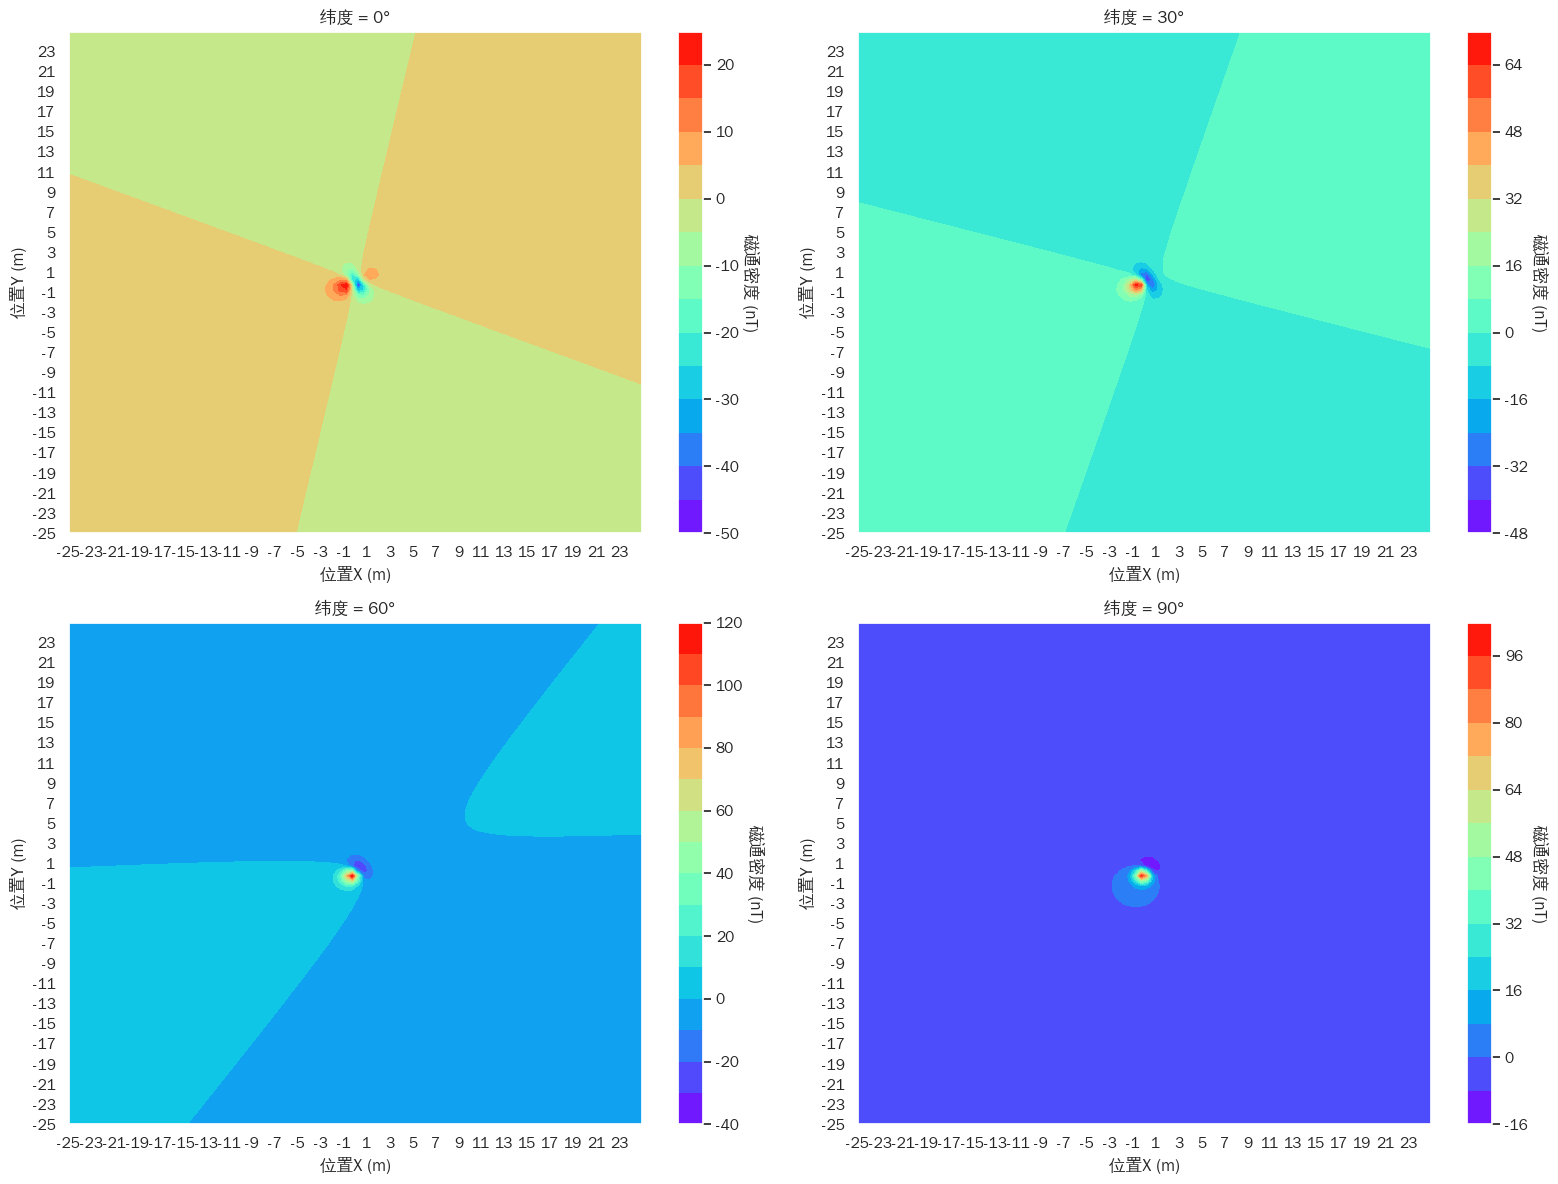

In [12]:
Raw_visualization_dict = {

    'height': 16,
    'width': 12,
    'n_model_aug': None,  # Not yet
    'n_dipoles': None,  # Not yet

}

height = Raw_visualization_dict['height']
width = Raw_visualization_dict['width']
n_model_aug = Raw_visualization_dict['n_model_aug']
n_dipoles = Raw_visualization_dict['n_dipoles']

rows = 2
cols = 2

example_to_plot = 10

par_window = 100

Plot_X_array_raw(map_lenght, height, width, example_to_plot, lat_array, X_data_array_raw,
                 Parameters_array_raw, n_model_aug, n_dipoles, rows, cols, par_window)

<a name='4.2.1'></a>
### 4.2.1 Creating boxes per anomaly


In [13]:
def box_per_anomaly(N_latitudes, n_examples, h_array, map_lenght, zmax):
    """
    根据给定的参数生成一个包含多个异常的边界框。

    参数：
    N_latitudes (int): 纬度的个数。
    n_examples (int): 异常的个数。
    h_array (ndarray): 每个纬度上异常的高度数组。
    map_lenght (float): 地图的长度。
    zmax (float): 深度的最大值。

    返回：
    bbox (ndarray): 形状为(N_latitudes, n_examples, 4)的边界框数组。
    """

    # 这个函数要求深度的最小值为1米

    real_to_pixel = zmax / (map_lenght * 2)

    if h_array[0] != 1:
        print("Error, Depth min has to be 1")

    bbox = np.zeros((N_latitudes, n_examples, 4))

    x0, y0 = (zmax / 2, zmax / 2)

    for lat_i in range(N_latitudes):
        if lat_i == 0:
            w_base = 3.7 * real_to_pixel
            h_base = 5.4 * real_to_pixel
            w_in = 0.5 * real_to_pixel
            h_in = 0.67 * real_to_pixel
        elif lat_i == 1:
            w_base = 4.6 * real_to_pixel
            h_base = 5.2 * real_to_pixel
            w_in = 0.5 * real_to_pixel
            h_in = 0.8 * real_to_pixel
        elif lat_i == 2:
            w_base = 3.4 * real_to_pixel
            h_base = 4.2 * real_to_pixel
            w_in = 0.5 * real_to_pixel
            h_in = 0.65 * real_to_pixel
        else:
            w_base = 3.6 * real_to_pixel
            h_base = 3.6 * real_to_pixel
            w_in = 0.40 * real_to_pixel
            h_in = 0.40 * real_to_pixel

        for h_n in range(n_examples):
            if h_n == 0:
                bbox[lat_i, h_n, :] = np.array(
                    [x0 - (w_base / 2), y0 - (h_base / 2), w_base, h_base])
            elif h_n < h_array.shape[0]:
                bbox[lat_i, h_n, 0] = bbox[lat_i, h_n - 1, 0] - (w_in / 2)
                bbox[lat_i, h_n, 1] = bbox[lat_i, h_n - 1, 1] - (h_in / 2)
                bbox[lat_i, h_n, 2] = bbox[lat_i, h_n - 1, 2] + w_in
                bbox[lat_i, h_n, 3] = bbox[lat_i, h_n - 1, 3] + h_in
            else:
                bbox[lat_i, h_n, :] = bbox[lat_i, h_n - h_array.shape[0], :]

    return bbox

In [14]:
def box_per_orientation(rotation, box_anomaly):
    """
    根据旋转角度和边界框异常值生成一系列调整后的边界框

    参数：
    rotation：旋转角度，数组格式，单位为度
    box_anomaly：边界框异常值，多维数组

    返回值：
    bbox_rot：调整后的边界框，多维数组

    """

    # 计算实际像素长度
    real_to_pixel = zmax/(map_lenght*2)

    # 获取纬度数量
    N_latitudes = box_anomaly.shape[0]

    # 获取旋转角度数量
    n_rot = rotation.shape[0]

    # 获取例子数量
    n_examples = box_anomaly.shape[1]

    # 初始化调整后的边界框数组
    bbox_rot = np.zeros((N_latitudes, n_rot+1, n_examples, 4))

    # 设置坐标原点
    x0, y0 = (0, 0)

    # 遍历纬度
    for lat_i in range(N_latitudes):

        # 遍历旋转角度
        for idx, i_rot in enumerate(rotation):

            # 遍历例子
            for h_n in range(n_examples):

                # 针对特定旋转角度进行处理
                if i_rot == 0 or i_rot == 180 or i_rot == 360:
                    bbox_rot[lat_i, idx, h_n, :] = box_anomaly[lat_i, h_n, :]
                else:
                    # 计算基准宽度
                    rot_w_base = (
                        box_anomaly[lat_i, h_n, 3] - box_anomaly[lat_i, h_n, 2]) / 90

                    # 根据旋转角度不同进行计算
                    if 0 < i_rot <= 90:
                        rot_int = rot_w_base * i_rot
                    elif 90 < i_rot <= 180:
                        rot_int = rot_w_base * (180 - i_rot)
                    elif 180 < i_rot <= 270:
                        rot_int = rot_w_base * (i_rot - 180)
                    elif 270 < i_rot < 360:
                        rot_int = rot_w_base * (360 - i_rot)

                    # 计算调整后的边界框坐标
                    bbox_rot[lat_i, idx, h_n,
                             0] = box_anomaly[lat_i, h_n, 0] - rot_int/2
                    bbox_rot[lat_i, idx, h_n,
                             1] = box_anomaly[lat_i, h_n, 1] + rot_int/2
                    bbox_rot[lat_i, idx, h_n,
                             2] = box_anomaly[lat_i, h_n, 2] + rot_int
                    bbox_rot[lat_i, idx, h_n,
                             3] = box_anomaly[lat_i, h_n, 3] - rot_int

    return bbox_rot

In [15]:
rotation = np.arange(0, 360, 30)

box_anomaly = box_per_anomaly(
    N_latitudes, n_examples, h_array, map_lenght, zmax)

box_orientation = box_per_orientation(rotation, box_anomaly)

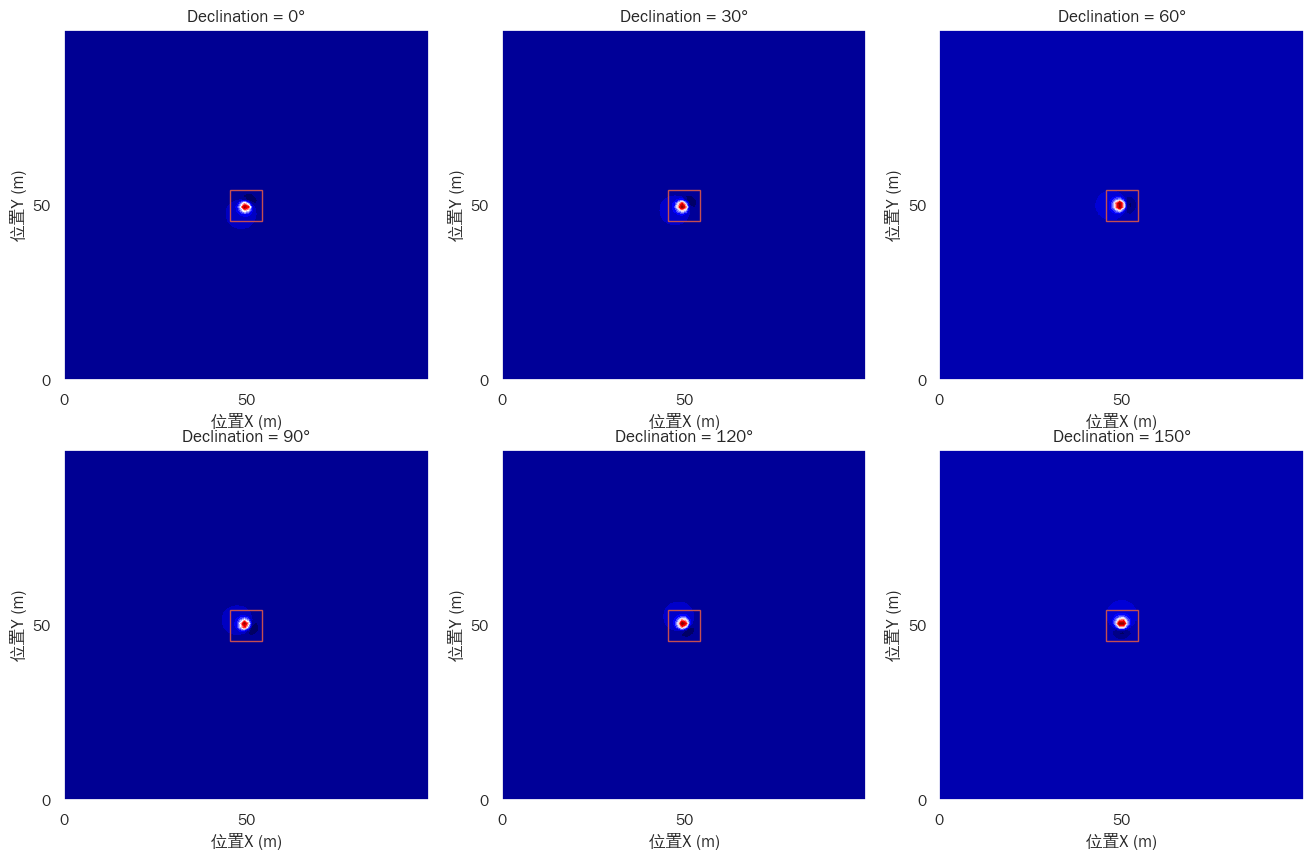

In [20]:
# %matplotlib auto
pixel_to_real = ((map_lenght*2)/zmax)  # 计算像素到真实坐标的比例
real_to_pixel = zmax/(map_lenght*2)  # 计算真实坐标到像素的比例

X = np.linspace(0, zmax, zmax)  # 在真实坐标系中生成X轴等差数组
Y = np.linspace(0, zmax, zmax)  # 在真实坐标系中生成Y轴等差数组

height_2 = 10  # 图像的高度
width_2 = 16  # 图像的宽度

lat = 3  # 选择纬度
example_to_plot = 10  # 选择要绘制的示例

rot_n = 0  # 选择旋转角度
idx = np.where(rotation == rot_n)[0][0]  # 获取指定旋转角度的索引位置

fig, axs = plt.subplots(2, 3, figsize=(width_2, height_2))  # 创建一个2行3列的图像对象
axs = axs.ravel()  # 将图像对象的轴数组拉平

for rot_idx, rot in enumerate(rotation[:6]):  # 遍历前6个旋转角度
    x0 = box_orientation[lat, rot_idx,
                         example_to_plot, 0]  # 获取框的中心点在真实坐标系中的x坐标
    y0 = box_orientation[lat, rot_idx,
                         example_to_plot, 1]  # 获取框的中心点在真实坐标系中的y坐标
    bwidth = box_orientation[lat, rot_idx, example_to_plot, 2]  # 获取框在真实坐标系中的宽度
    bheight = box_orientation[lat, rot_idx,
                              example_to_plot, 3]  # 获取框在真实坐标系中的高度

    rect_real = Rectangle((x0, y0), bwidth, bheight, edgecolor='r',
                          facecolor="none")  # 创建一个矩形对象表示框在真实坐标系中的位置

    cp = axs[rot_idx].contourf(X, Y, ndimage.rotate(X_data_array_raw[lat, example_to_plot, :, :], rot, axes=(
        0, 1), reshape=False), levels=16, cmap='seismic')  # 绘制旋转后的数据图像
    axs[rot_idx].set_xlabel('位置X (m)')  # 设置x轴标签
    axs[rot_idx].set_ylabel('位置Y (m)')  # 设置y轴标签
    axs[rot_idx].set_xticks(np.arange(0, zmax, step=50))  # 设置x轴刻度
    axs[rot_idx].set_yticks(np.arange(0, zmax, step=50))  # 设置y轴刻度
    axs[rot_idx].add_patch(rect_real)  # 将矩形框添加到图像中
    axs[rot_idx].set_title(f'Declination = {rot}°')  # 设置图像标题

<a name='4.5'></a>
### 4.5 Creating X array (counting number of dipoles and data augmentation)

In [21]:
def X_array(N_dipoles_f, N_parameters_f, dist_min_i, X_data_pad, bbox, rotation, h_array, new_size, lat_array):

    #### Number of dipoles ###

    N_dipoles = N_dipoles_f
    N_parameters = N_parameters_f
    N_h = h_array.shape[0]

    ##########################

    h_counting = np.arange(0, N_h, 1)

    h_idx = np.tile(h_counting, N_h)

    ##########################

    N_lat = X_data_pad.shape[0]
    n_examples = X_data_pad.shape[1]
    zmax = int(X_data_pad.shape[2])
    border_o = int((zmax)/2)
    # border_yolo = int((416-zmax)/2)

    ##########################

    conversion = (2*map_lenght)/zmax

    yolo_conversion = (new_size/zmax)

    ##########################

    dist_min = dist_min_i / conversion

    ##########################

    X_data = np.zeros((N_lat, N_dipoles, n_examples, new_size, new_size))
    Position = np.zeros((N_lat, N_dipoles, n_examples, N_dipoles*2))
    bbox_f = np.zeros((N_lat, N_dipoles, n_examples, 5*N_dipoles))
    lat_f = np.zeros((N_lat, N_dipoles, n_examples, 1))

    No_pad_left = int((zmax) - zmax/2)
    No_pad_right = int((zmax) + zmax/2)

    Position_array_to_add = np.zeros((N_lat, N_dipoles, n_examples, 2))

    w_in = 1

    w_ch = 0
    h_ch = 0

    limit = (zmax/2) - 1

    for i_lat in tqdm(range(0, N_lat, 1)):

        for n_dipoles_i in range(0, N_dipoles, 1):

            for i_n_examples in range(0, n_examples, 1):

                # dist_min_f = int(5 + (h_idx[i_n_examples]*1.5))

                if n_dipoles_i == 0:

                    ##########################

                    position_x = random.randint(-limit, limit)
                    position_y = random.randint(-limit, limit)

                    Position_array_to_add[i_lat, n_dipoles_i,
                                          i_n_examples, 0] = position_x + zmax/2
                    Position_array_to_add[i_lat, n_dipoles_i,
                                          i_n_examples, 1] = position_y + zmax/2

                    ##########################

                    rot_n = random.choice(rotation)

                    if (i_lat == 3):

                        rot_n = 0

                    elif (i_lat == 0) and rot_n >= 180:

                        rot_n = rot_n - 180

                    img = X_data_pad[i_lat, i_n_examples, :, :]

                    X_array_rot = ndimage.rotate(
                        img, rot_n, axes=(0, 1), reshape=False)

                    X_data_padded = cv2.copyMakeBorder(
                        X_array_rot, border_o, border_o, border_o, border_o, 0)

                    X_data_x = np.roll(X_data_padded, position_x, axis=1)
                    X_data_y = np.roll(X_data_x, position_y, axis=0)

                    X_array_os = X_data_y[No_pad_left:No_pad_right,
                                          No_pad_left:No_pad_right]

                    X_array_yolo = cv2.resize(
                        X_array_os, (new_size, new_size), interpolation=cv2.INTER_CUBIC)

                    X_data[i_lat, n_dipoles_i,
                           i_n_examples, :, :] = X_array_yolo

                    ##########################

                    Position[i_lat, n_dipoles_i:, i_n_examples, (n_dipoles_i)*2:(n_dipoles_i+1)*2] = np.round(
                        Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, :] * yolo_conversion, 0)

                    ##########################

                    # Box latitude
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           0 + (5*n_dipoles_i)] = int(i_lat)

                    # Box conditions
                    x_o = ((bbox[i_lat, np.where(rotation == rot_n)[
                           0][0], i_n_examples, 0]) + position_x) * yolo_conversion
                    y_o = ((bbox[i_lat, np.where(rotation == rot_n)[
                           0][0], i_n_examples, 1]) + position_y) * yolo_conversion
                    w_o = bbox[i_lat, np.where(rotation == rot_n)[
                        0][0], i_n_examples, 2] * yolo_conversion
                    h_o = bbox[i_lat, np.where(rotation == rot_n)[
                        0][0], i_n_examples, 3] * yolo_conversion

                    limit_yolo = zmax * yolo_conversion

                    # condition 1
                    if (x_o < 0) and (y_o < 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o > 0):
                        x = 0
                        y = 0
                        w_ch = -x_o
                        h_ch = -y_o
                    # Condition 2
                    elif (x_o >= 0) and (y_o < 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = x_o
                        y = 0
                        w_ch = 0
                        h_ch = -y_o

                    # Condition 3
                    elif (x_o >= 0) and (y_o < 0) and (x_o+w_o > limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = x_o
                        y = 0
                        w_ch = (x_o+w_o) - limit_yolo
                        h_ch = -y_o

                    # Condition 4
                    elif (x_o >= 0) and (y_o >= 0) and (x_o+w_o > limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = x_o
                        y = y_o
                        w_ch = (x_o+w_o) - limit_yolo
                        h_ch = 0

                    # Condition 5
                    elif (x_o >= 0) and (y_o >= 0) and (x_o+w_o > limit_yolo) and (y_o+h_o > limit_yolo):
                        x = x_o
                        y = y_o
                        w_ch = (x_o+w_o) - limit_yolo
                        h_ch = (y_o+h_o) - limit_yolo

                    # Condition 6
                    elif (x_o >= 0) and (y_o >= 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o > limit_yolo):
                        x = x_o
                        y = y_o
                        w_ch = 0
                        h_ch = (y_o+h_o) - limit_yolo

                    # Condition 7
                    elif (x_o < 0) and (y_o >= 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o > limit_yolo):
                        x = 0
                        y = y_o
                        w_ch = -x_o
                        h_ch = (y_o+h_o) - limit_yolo

                    # Condition 8:
                    elif (x_o < 0) and (y_o >= 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = 0
                        y = y_o
                        w_ch = -x_o
                        h_ch = 0

                    else:
                        x = x_o
                        y = y_o
                        w_ch = 0
                        h_ch = 0

                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           1 + (5*n_dipoles_i)] = x
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           2 + (5*n_dipoles_i)] = y
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           3 + (5*n_dipoles_i)] = w_o - w_ch
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           4 + (5*n_dipoles_i)] = h_o - h_ch

                else:

                    while w_in == 1:

                        in_a = 0

                        position_x = random.randint(-limit, limit)
                        position_y = random.randint(-limit, limit)

                        X_c = (
                            (position_x) - (Position_array_to_add[i_lat, :, i_n_examples, 0] - zmax/2))

                        Y_c = (
                            (position_y) - (Position_array_to_add[i_lat, :, i_n_examples, 1] - zmax/2))

                        distance = np.sqrt(X_c**2 + Y_c**2)

                        if np.all(dist_min < distance):

                            break

                        else:

                            if in_a > 150:

                                print("Looping forever?")

                            in_a += 1

                            continue

                    Position_array_to_add[i_lat, n_dipoles_i,
                                          i_n_examples, 0] = position_x + zmax/2
                    Position_array_to_add[i_lat, n_dipoles_i,
                                          i_n_examples, 1] = position_y + zmax/2

                    ##########################

                    if i_lat == 3:

                        rot_n = 0

                    else:

                        rot_n = random.choice(rotation)

                    # new_example = np.random.randint(n_examples)

                    img = X_data_pad[i_lat, i_n_examples, :, :]

                    X_array_rot = ndimage.rotate(
                        img, rot_n, axes=(0, 1), reshape=False)

                    X_data_padded = cv2.copyMakeBorder(
                        X_array_rot, border_o, border_o, border_o, border_o, 0)

                    X_data_x = np.roll(X_data_padded, position_x, axis=1)
                    X_data_y = np.roll(X_data_x, position_y, axis=0)

                    X_array_os = X_data_y[No_pad_left:No_pad_right,
                                          No_pad_left:No_pad_right]

                    X_array_yolo = cv2.resize(
                        X_array_os, (new_size, new_size), interpolation=cv2.INTER_CUBIC)

                    X_data[i_lat, n_dipoles_i, i_n_examples, :, :] = X_data[i_lat,
                                                                            n_dipoles_i-1, i_n_examples, :, :] + X_array_yolo

                    ##########################

                    Position[i_lat, n_dipoles_i:, i_n_examples, (n_dipoles_i)*2:(n_dipoles_i+1)*2] = np.round(
                        Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, :] * yolo_conversion, 0)

                    # Box latitude
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           0 + (5*n_dipoles_i)] = int(i_lat)

                    # Box conditions
                    x_o = ((bbox[i_lat, np.where(rotation == rot_n)[
                           0][0], i_n_examples, 0]) + position_x) * yolo_conversion
                    y_o = ((bbox[i_lat, np.where(rotation == rot_n)[
                           0][0], i_n_examples, 1]) + position_y) * yolo_conversion
                    w_o = bbox[i_lat, np.where(rotation == rot_n)[
                        0][0], i_n_examples, 2] * yolo_conversion
                    h_o = bbox[i_lat, np.where(rotation == rot_n)[
                        0][0], i_n_examples, 3] * yolo_conversion

                    limit_yolo = zmax * yolo_conversion

                    # condition 1
                    if (x_o < 0) and (y_o < 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o > 0):
                        x = 0
                        y = 0
                        w_ch = -x_o
                        h_ch = -y_o
                    # Condition 2
                    elif (x_o >= 0) and (y_o < 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = x_o
                        y = 0
                        w_ch = 0
                        h_ch = -y_o

                    # Condition 3
                    elif (x_o >= 0) and (y_o < 0) and (x_o+w_o > limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = x_o
                        y = 0
                        w_ch = (x_o+w_o) - limit_yolo
                        h_ch = -y_o

                    # Condition 4
                    elif (x_o >= 0) and (y_o >= 0) and (x_o+w_o > limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = x_o
                        y = y_o
                        w_ch = (x_o+w_o) - limit_yolo
                        h_ch = 0

                    # Condition 5
                    elif (x_o >= 0) and (y_o >= 0) and (x_o+w_o > limit_yolo) and (y_o+h_o > limit_yolo):
                        x = x_o
                        y = y_o
                        w_ch = (x_o+w_o) - limit_yolo
                        h_ch = (y_o+h_o) - limit_yolo

                    # Condition 6
                    elif (x_o >= 0) and (y_o >= 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o > limit_yolo):
                        x = x_o
                        y = y_o
                        w_ch = 0
                        h_ch = (y_o+h_o) - limit_yolo

                    # Condition 7
                    elif (x_o < 0) and (y_o >= 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o > limit_yolo):
                        x = 0
                        y = y_o
                        w_ch = -x_o
                        h_ch = (y_o+h_o) - limit_yolo

                    # Condition 8:
                    elif (x_o < 0) and (y_o >= 0) and (x_o+w_o <= limit_yolo) and (y_o+h_o <= limit_yolo):
                        x = 0
                        y = y_o
                        w_ch = -x_o
                        h_ch = 0

                    else:
                        x = x_o
                        y = y_o
                        w_ch = 0
                        h_ch = 0

                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           1 + (5*n_dipoles_i)] = x
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           2 + (5*n_dipoles_i)] = y
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           3 + (5*n_dipoles_i)] = w_o - w_ch
                    bbox_f[i_lat, n_dipoles_i:, i_n_examples,
                           4 + (5*n_dipoles_i)] = h_o - h_ch

    return X_data, Position, bbox_f, lat_f

In [22]:
#### Data augmentation ####
N_models = 1

### Number of dipoles and min distance between dipoles ###
N_parameters_f = 3  # Latitude, Depth, Radius
N_dipoles_f = 10

##########################
dist_min_i = 2  # meters, to avoid coalescence

##########################
rotation = np.arange(0, 360, 30)

##########################
new_size = 416

##########################
X_data_f = np.zeros((N_models, N_latitudes, N_dipoles_f,
                    n_examples, new_size, new_size))
Position_f = np.zeros(
    (N_models, N_latitudes, N_dipoles_f, n_examples, 2*N_dipoles_f))
bbox_f = np.zeros((N_models, N_latitudes, N_dipoles_f,
                  n_examples, 5*N_dipoles_f))
lat_array_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples, 1))

for i_n_models in range(N_models):

    X_data_f[i_n_models, :, :, :, :], Position_f[i_n_models, :, :, :, :], bbox_f[i_n_models, :, :, :, :], lat_array_f[i_n_models, :, :,  :, :] = X_array(N_dipoles_f, N_parameters_f, dist_min_i, X_data_array_raw, box_orientation, rotation, h_array, new_size, lat_array)

    print(f"Model: {i_n_models+1} ready")

Model: 1 ready


Plotting model: 64
Dipole_0: x0: 297.9, y0: 271.6, w: 44.9, h:30.8
Dipole_1: x0: 169.5, y0: 42.3, w: 35.5, h:40.2
Dipole_2: x0: 144.5, y0: 387.6, w: 35.5, h:28.4
Dipole_3: x0: 183.7, y0: 123.7, w: 40.2, h:35.5
Dipole_4: x0: 354.3, y0: 177.8, w: 40.2, h:35.5
Dipole_5: x0: 283.6, y0: 94.6, w: 40.2, h:35.5
Dipole_6: x0: 323.4, y0: 29.8, w: 35.5, h:40.2
Dipole_7: x0: 360.8, y0: 321.0, w: 35.5, h:40.2


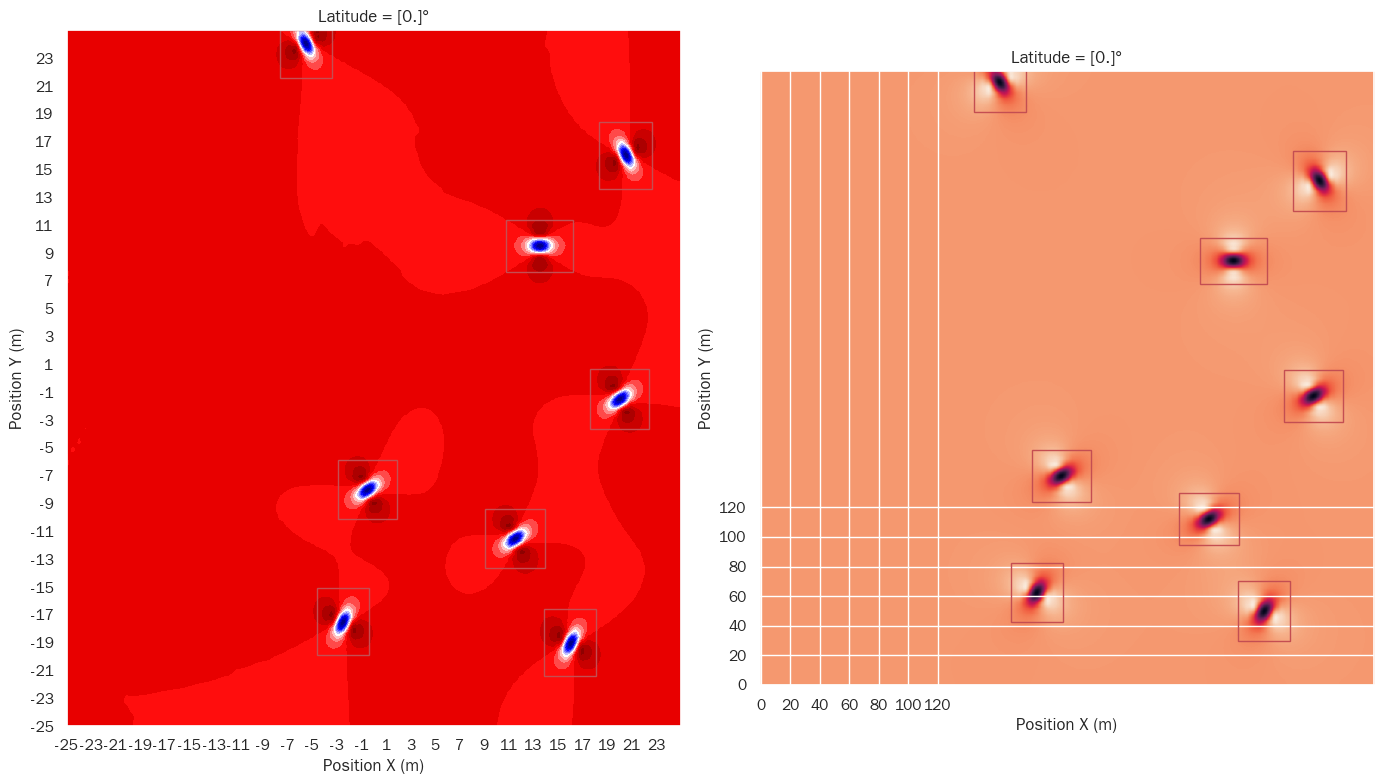

In [23]:
model_to_plot_l = np.random.randint(X_data_f.shape[3])
# model_to_plot_l = 4

data_augmentation_n = 0

height_2 = 14
width_2 = 8

n_lat_to_plot = 1

n_dipoles_tp = 8

X_data_tp = X_data_f[data_augmentation_n, :, n_dipoles_tp-1, :, :, :]

Plot_X_data(map_lenght, height_2, width_2, model_to_plot_l, X_data_tp, Position_f[data_augmentation_n, :, n_dipoles_tp-1, :, :],
            bbox_f[data_augmentation_n, :, n_dipoles_tp-1, :, :], n_dipoles_tp, lat_array_f[data_augmentation_n, :, n_dipoles_tp-1, 0, :], n_lat_to_plot)

In [24]:
X_data_f = np.moveaxis(X_data_f, 1, 0)
Position_f = np.moveaxis(Position_f, 1, 0)
bbox_f = np.moveaxis(bbox_f, 1, 0)
lat_array_f = np.moveaxis(lat_array_f, 1, 0)

print(f"X_data shape: {X_data_f.shape}")
print(f"Position shape: {Position_f.shape}")
print(f"Box f shape: {bbox_f.shape}")
print(f"Lat f shape: {lat_array_f.shape}")

X_data shape: (4, 1, 10, 256, 416, 416)
Position shape: (4, 1, 10, 256, 20)
Box f shape: (4, 1, 10, 256, 50)
Lat f shape: (4, 1, 10, 256, 1)


### rearranging database shape

In [25]:
def rearrange_dipoles(X_data_array, bbox_f, Y_pos, lat_array_f):

    X_data_array_final = X_data_array.reshape(
        X_data_array.shape[0], X_data_array.shape[1]*X_data_array.shape[2]*X_data_array.shape[3], X_data_array.shape[4], X_data_array.shape[5])

    bbox_final = bbox_f.reshape(bbox_f.shape[0], bbox_f.shape[1]*bbox_f.shape[2]*bbox_f.shape[3],
                                bbox_f.shape[4])

    Y_pos_final = Y_pos.reshape(Y_pos.shape[0], Y_pos.shape[1]*Y_pos.shape[2]*Y_pos.shape[3],
                                Y_pos.shape[4])

    lat_array_final = lat_array_f.reshape(lat_array_f.shape[0], lat_array_f.shape[1]*lat_array_f.shape[2]*lat_array_f.shape[3],
                                          lat_array_f.shape[4])

    return X_data_array_final, bbox_final, Y_pos_final, lat_array_final

In [26]:
X_array_final, bbox_final, Y_position, lat_array_final = rearrange_dipoles(
    X_data_f, bbox_f, Position_f, lat_array_f)

In [27]:
print(f'X_data shape:{X_array_final.shape}')
print(f'Y_position shape: {Y_position.shape}')
print(f'bbox_final shape: {bbox_final.shape}')
print(f'lat_array_final: {lat_array_final.shape}')

X_data shape:(4, 2560, 416, 416)
Y_position shape: (4, 2560, 20)
bbox_final shape: (4, 2560, 50)
lat_array_final: (4, 2560, 1)


In [31]:
random_seed_2 = 10

for lat_i in tqdm(range(X_data_f.shape[0])):

    X_array_final[lat_i, :] = shuffle(
        X_array_final[lat_i, :], random_state=random_seed_2)
    Y_position[lat_i, :] = shuffle(
        Y_position[lat_i, :], random_state=random_seed_2)
    bbox_final[lat_i, :] = shuffle(
        bbox_final[lat_i, :], random_state=random_seed_2)
    lat_array_final[lat_i, :] = shuffle(
        lat_array_final[lat_i, :], random_state=random_seed_2)

100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


In [32]:
train_rate = 0.70
dev_rate = 0.25
test_rate = 0.05

examples_t = X_array_final.shape[1]

X_train = X_array_final[0, :int(examples_t*train_rate), :, :]
Y_pos_train = Y_position[0, :int(examples_t*train_rate), :]
Bbox_train = bbox_final[0, :int(examples_t*train_rate), :]
Lat_train = lat_array_final[0, :int(examples_t*train_rate), :]

X_dev = X_array_final[0, int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)), :, :]
Y_pos_dev = Y_position[0, int(examples_t*train_rate)
                              :int(examples_t*(train_rate+dev_rate)), :]
Bbox_dev = bbox_final[0, int(examples_t*train_rate)
                             :int(examples_t*(train_rate+dev_rate)), :]
Lat_dev = lat_array_final[0, int(
    examples_t*train_rate):int(examples_t*(train_rate+dev_rate)), :]

X_test = X_array_final[0, int(examples_t*(train_rate+dev_rate)):, :, :]
Y_pos_test = Y_position[0, int(examples_t*(train_rate+dev_rate)):, :]
Bbox_test = bbox_final[0, int(examples_t*(train_rate+dev_rate)):, :]
Lat_test = lat_array_final[0, int(examples_t*(train_rate+dev_rate)):, :]

In [33]:
def rearrange_final(X_data_array, Y_pos, Bbox, Lat, N_dipoles_f):

    X_data_array_final = X_data_array.reshape(
        X_data_array.shape[0], X_data_array.shape[1], X_data_array.shape[2], 1)

    Y_pos_final = Y_pos.reshape(Y_pos.shape[0], N_dipoles_f, 2)

    Bbox_final = Bbox.reshape(Bbox.shape[0], N_dipoles_f, 5)

    Lat_final = Lat.reshape(Lat.shape[0], 1)

    return X_data_array_final, Y_pos_final, Bbox_final, Lat_final

In [34]:
X_train, Y_pos_train, Bbox_train, Lat_train = rearrange_final(
    X_train, Y_pos_train, Bbox_train, Lat_train, N_dipoles_f)

X_dev, Y_pos_dev, Bbox_dev, Lat_dev = rearrange_final(
    X_dev, Y_pos_dev, Bbox_dev, Lat_dev, N_dipoles_f)

X_test, Y_pos_test, Bbox_test, Lat_test = rearrange_final(
    X_test, Y_pos_test, Bbox_test, Lat_test, N_dipoles_f)

In [35]:
print(X_train.shape, Bbox_train.shape, Y_pos_train.shape, Lat_train.shape)
print(X_dev.shape, Bbox_dev.shape, Y_pos_dev.shape, Lat_dev.shape)
print(X_test.shape, Bbox_test.shape, Y_pos_test.shape, Lat_test.shape)

(1792, 416, 416, 1) (1792, 10, 5) (1792, 10, 2) (1792, 1)
(640, 416, 416, 1) (640, 10, 5) (640, 10, 2) (640, 1)
(128, 416, 416, 1) (128, 10, 5) (128, 10, 2) (128, 1)


In [39]:
def shuffle_final(X, pos, box, lat, random_seed_3):

    X = shuffle(X[:], random_state=random_seed_3)
    pos = shuffle(pos[:], random_state=random_seed_3)
    box = shuffle(box[:], random_state=random_seed_3)
    lat = shuffle(lat[:], random_state=random_seed_3)

    return X, pos, box, lat

In [40]:
random_seed_3 = 30

X_train, Y_pos_train, Bbox_train, Lat_train = shuffle_final(
    X_train, Y_pos_train, Bbox_train, Lat_train, random_seed_3)
X_dev, Y_pos_dev, Bbox_dev, Lat_dev = shuffle_final(
    X_dev, Y_pos_dev, Bbox_dev, Lat_dev, random_seed_3)
X_test, Y_pos_test, Bbox_test, Lat_test = shuffle_final(
    X_test, Y_pos_test, Bbox_test, Lat_test, random_seed_3)

In [41]:
print("Total examples: {:.0f}".format(
    X_train.shape[0]+X_dev.shape[0]+X_test.shape[0]))

Total examples: 2560


<a name='4.7'></a>
### X,Y data visualization


Plotting model: 363
Dipole_0: x0: 37.0, y0: 108.0, w: 40, h:35
Dipole_1: x0: 412.0, y0: 408.0, w: 26, h:23
Dipole_2: x0: 71.0, y0: 166.0, w: 35, h:40
Dipole_3: x0: 54.0, y0: 345.0, w: 30, h:44
Dipole_4: x0: 183.0, y0: 50.0, w: 30, h:44
Dipole_5: x0: 0.0, y0: 0.0, w: 0, h:0
Dipole_6: x0: 0.0, y0: 0.0, w: 0, h:0
Dipole_7: x0: 0.0, y0: 0.0, w: 0, h:0
Dipole_8: x0: 0.0, y0: 0.0, w: 0, h:0
Dipole_9: x0: 0.0, y0: 0.0, w: 0, h:0


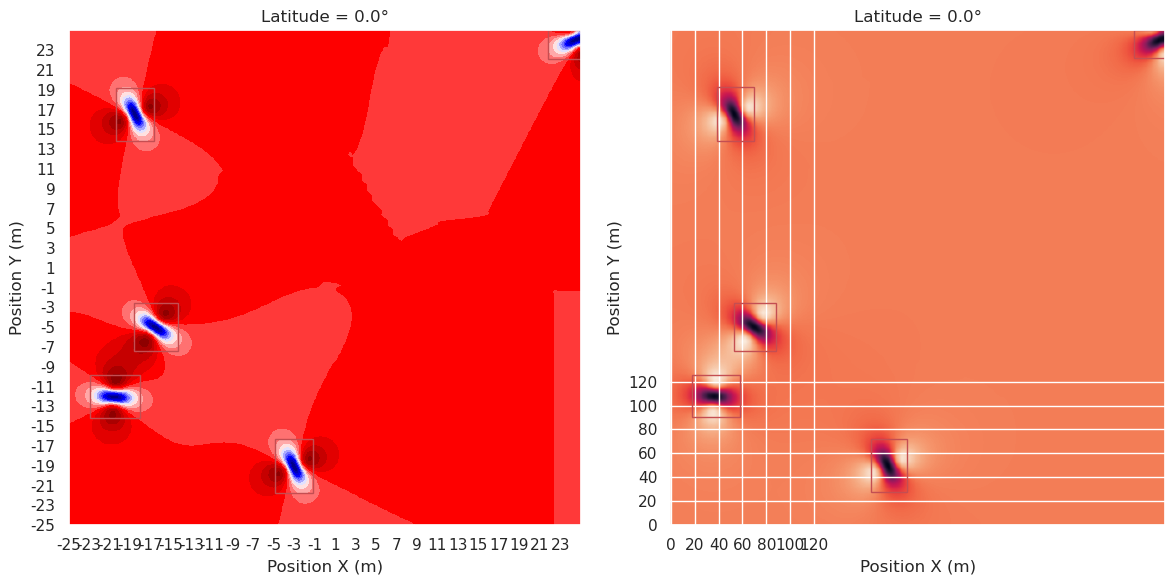

In [42]:
model_to_plot_l = int(np.random.randint(0, X_train.shape[0], 1))
# model_to_plot_l = 9

height_2 = 12
width_2 = 6

Plot_X_data_final(map_lenght, height_2, width_2, model_to_plot_l,
                  X_train[:, :, :, 0], Y_pos_train[:, :, :], Bbox_train[:, :, :], N_dipoles_f, Lat_train, N_latitudes)

### Adding Gaussian noise

In [43]:
def gaussian_noise_models(mean, var, sigma, n_models_with_noise, zmax, X_data_array, Bbox, Y_pos):

    X_data_array_with_noise = np.zeros(
        (n_models_with_noise, zmax, zmax, X_data_array.shape[3]))
    Bbox_f = np.zeros((n_models_with_noise, Bbox.shape[1], Bbox.shape[2]))
    Y_pos_f = np.zeros((n_models_with_noise, Y_pos.shape[1], Y_pos.shape[2]))

    n_i = random.sample(range(X_data_array.shape[0]-1), n_models_with_noise)

    for i_noise_models in range(0, n_models_with_noise, 1):

        m = n_i[i_noise_models]

        if (0 > np.max(X_data_array[m, :, :, 0])) and (np.max(X_data_array[m, :, :, 0]) < 10):

            var = 0.01

        elif (-10 < np.min(X_data_array[m, :, :, 0])) and (np.min(X_data_array[m, :, :, 0]) < 0):

            var = 0.01

        elif (10 > np.max(X_data_array[m, :, :, 0])) and (np.max(X_data_array[m, :, :, 0]) < 100):

            var = 1

        elif (-100 < np.min(X_data_array[m, :, :, 0])) and (np.min(X_data_array[m, :, :, 0]) < -10):

            var = 1

        elif (100 > np.max(X_data_array[m, :, :, 0])) and (np.max(X_data_array[m, :, :, 0]) < 1000):

            var = 5

        elif (-1000 < np.min(X_data_array[m, :, :, 0])) and (np.min(X_data_array[m, :, :, 0]) < -100):

            var = 5

        else:
            var = 10

        sigma = var ** 0.5

        gaussian = np.random.normal(mean, sigma, (zmax, zmax))

        X_data_array_with_noise[i_noise_models, :, :,
                                0] = X_data_array[m, :, :, 0] + gaussian

        Bbox_f[i_noise_models, :, :] = Bbox[m, :, :]

        Y_pos_f[i_noise_models, :, :] = Y_pos[m, :, :]

    return X_data_array_with_noise, Bbox_f, Y_pos_f, n_i

In [44]:
Gaussian_noise_dict = {

    "mean": 0,
    "var": 0.1,
    "n_models_with_noise": 100  # Number of models with noise

}

sigma = Gaussian_noise_dict['var'] ** 0.5

X_data_array_with_noise, Bbox_train_noise, Y_pos_train_noise, n_i = gaussian_noise_models(Gaussian_noise_dict['mean'], Gaussian_noise_dict['var'],
                                                                                          sigma, Gaussian_noise_dict[
                                                                                              'n_models_with_noise'],
                                                                                          X_train.shape[1], X_train, Bbox_train, Y_pos_train)

Gaussian noise models visualization

15
Dipole_0: x0: 337.0, y0: 108.0, w: 50.4, h:44.8
Dipole_1: x0: 83.0, y0: 92.0, w: 44.8, h:50.4
Dipole_2: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_3: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_4: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_5: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_6: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_7: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_8: x0: 0.0, y0: 0.0, w: 0.0, h:0.0
Dipole_9: x0: 0.0, y0: 0.0, w: 0.0, h:0.0


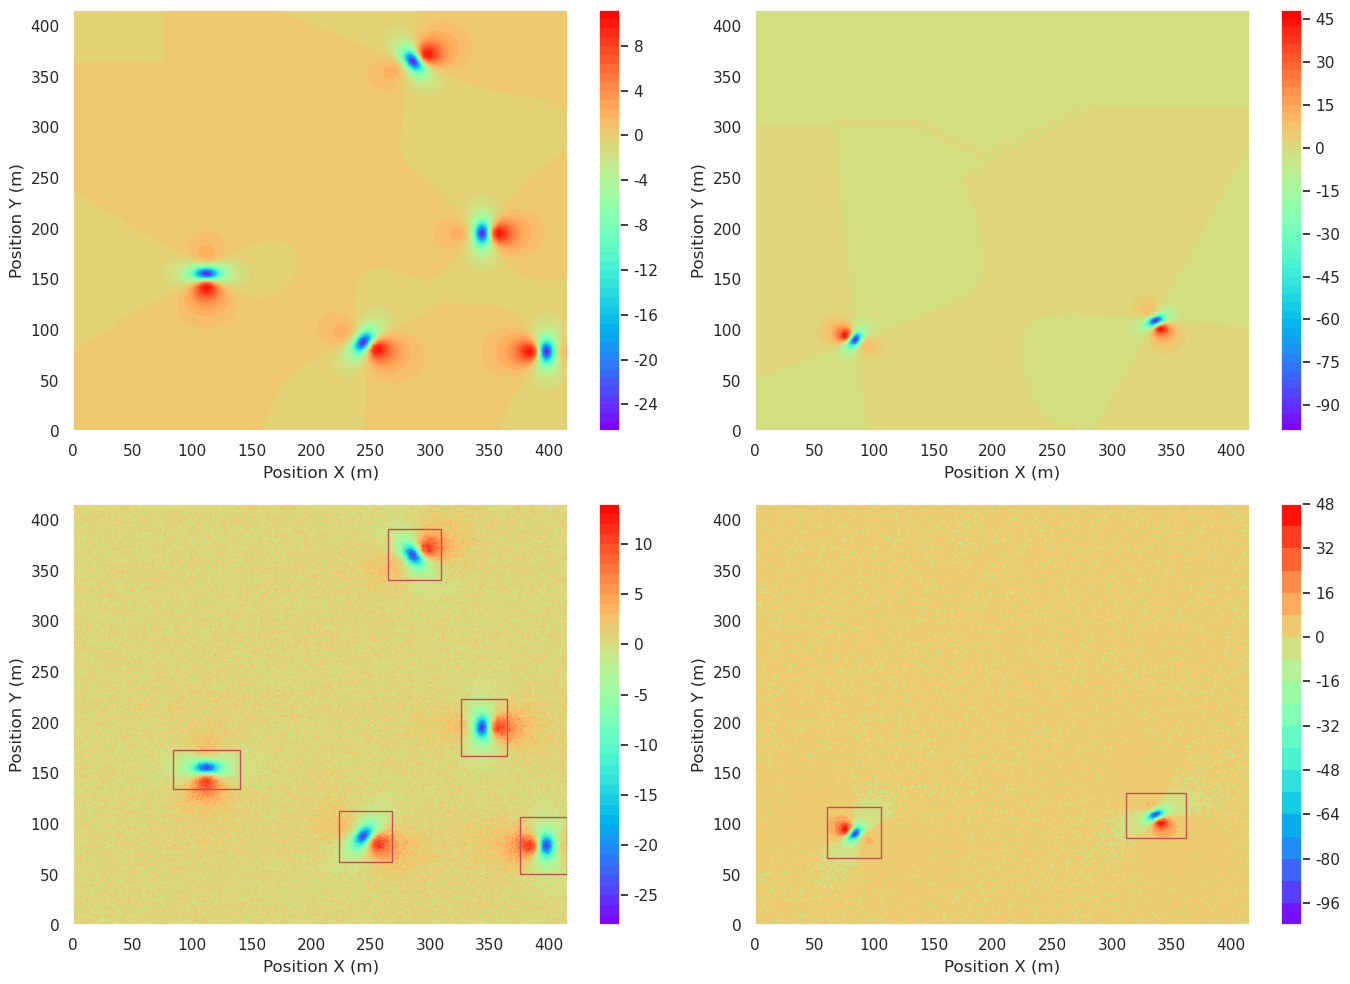

In [45]:
height_2 = 10
width_2 = 14

X = np.linspace(0, new_size, new_size)
Y = np.linspace(0, new_size, new_size)

model_to_plot_l = int(np.random.randint(
    0, X_data_array_with_noise.shape[0]-1, 1))
# model_to_plot_l = 436
print(model_to_plot_l)

##############################

fig, axs = plt.subplots(2, 2, figsize=(width_2, height_2))

axs = axs.ravel()

cp_0 = axs[0].contourf(X, Y, X_train[n_i[model_to_plot_l],
                       :, :, 0], levels=50, cmap='rainbow')
axs[0].set_xlabel('Position X (m)')
# axs[0].set_xticks(np.arange(-25, 25, step=5))
axs[0].set_ylabel('Position Y (m)')
# axs[0].set_yticks(np.arange(-25, 25, step=5))
clb = plt.colorbar(cp_0, ax=axs[0])

cp_1 = axs[1].contourf(
    X, Y, X_train[n_i[model_to_plot_l+1], :, :, 0], levels=50, cmap='rainbow')
axs[1].set_xlabel('Position X (m)')
# axs[1].set_xticks(np.arange(-25, 25, step=5))
axs[1].set_ylabel('Position Y (m)')
# axs[1].set_yticks(np.arange(-25, 25, step=5))
clb = plt.colorbar(cp_1, ax=axs[1])

cp_2 = axs[2].contourf(
    X, Y, X_data_array_with_noise[model_to_plot_l, :, :, 0], levels=50, cmap='rainbow')
axs[2].set_xlabel('Position X (m)')
# axs[2].set_xticks(np.arange(-25, 25, step=5))
axs[2].set_ylabel('Position Y (m)')
# axs[2].set_yticks(np.arange(-25, 25, step=5))
for n_ii in range(N_dipoles_f):
    x0 = Bbox_train_noise[model_to_plot_l, n_ii, 1]
    y0 = Bbox_train_noise[model_to_plot_l, n_ii, 2]
    bwidth = Bbox_train_noise[model_to_plot_l, n_ii, 3]
    bheight = Bbox_train_noise[model_to_plot_l, n_ii, 4]
    # print(f"Dipole_{n_ii}: x0: {np.round(x0,1)}, y0: {np.round(y0,1)}, w: {round(bwidth,1)}, h:{round(bheight,1)}")
    axs[2].add_patch(Rectangle((x0, y0), bwidth, bheight,
                     edgecolor='r', facecolor="none"))
clb = plt.colorbar(cp_2, ax=axs[2])

cp_3 = axs[3].contourf(
    X, Y, X_data_array_with_noise[model_to_plot_l+1, :, :, 0], levels=18, cmap='rainbow')
axs[3].set_xlabel('Position X (m)')
# axs[3].set_xticks(np.arange(-25, 25, step=5))
axs[3].set_ylabel('Position Y (m)')
# axs[3].set_yticks(np.arange(-25, 25, step=5))
for n_ii in range(N_dipoles_f):
    x0 = Bbox_train_noise[model_to_plot_l+1, n_ii, 1]
    y0 = Bbox_train_noise[model_to_plot_l+1, n_ii, 2]
    bwidth = Bbox_train_noise[model_to_plot_l+1, n_ii, 3]
    bheight = Bbox_train_noise[model_to_plot_l+1, n_ii, 4]
    print(
        f"Dipole_{n_ii}: x0: {np.round(Y_pos_train_noise[model_to_plot_l+1,n_ii,0],1)}, y0: {np.round(Y_pos_train_noise[model_to_plot_l+1,n_ii,1],1)}, w: {round(bwidth,1)}, h:{round(bheight,1)}")
    axs[3].add_patch(Rectangle((x0, y0), bwidth, bheight,
                     edgecolor='r', facecolor="none"))
clb = plt.colorbar(cp_3, ax=axs[3])


plt.tight_layout()

In [46]:
X_train = np.concatenate((X_train, X_data_array_with_noise), axis=0)
Bbox_train = np.concatenate((Bbox_train, Bbox_train_noise), axis=0)
Y_pos_train = np.concatenate((Y_pos_train, Y_pos_train_noise), axis=0)

In [47]:
random_seed_3 = 128

X_train = shuffle(X_train[:], random_state=random_seed_3)
Bbox_train = shuffle(Bbox_train[:], random_state=random_seed_3)
Y_pos_train = shuffle(Y_pos_train[:], random_state=random_seed_3)

In [48]:
N_total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]

print(f'Total number of examples : {N_total_examples}')
print(f'Train : {X_train.shape[0]}')
print(f'Dev : {X_dev.shape[0]}')
print(f'Test : {X_test.shape[0]}')

Total number of examples : 2660
Train : 1892
Dev : 640
Test : 128


### 4.8 YOLO format

In [ ]:
def convert_to_YOLO(IMG_size, X_array, Y_position, bbox_f, flag):

    YOLO_box = np.zeros((bbox_f.shape[0], N_dipoles_f, 5))

    for bb_n_models in range(bbox_f.shape[0]):

        # Normalize between 0 - 1

        image = (X_array[bb_n_models, :, :, :] - np.min(X_array[bb_n_models, :, :, :])) / (
            np.max(X_array[bb_n_models, :, :, :]) - np.min(X_array[bb_n_models, :, :, :]))

        # Converting to rgb

        image_t = np.uint8(image * 255)
        image_t = cv2.cvtColor(image_t, cv2.COLOR_GRAY2RGB)

        # Saving image

        im = Image.fromarray(image_t)
        im.save(f"{flag}_{bb_n_models+1}.jpg")

        for bb_n_dipoles in range(bbox_f.shape[1]):

            YOLO_box[bb_n_models, bb_n_dipoles,
                     0] = bbox_f[bb_n_models, bb_n_dipoles, 0]
            YOLO_box[bb_n_models, bb_n_dipoles,
                     1] = Y_position[bb_n_models, bb_n_dipoles, 0] / IMG_size[0]
            YOLO_box[bb_n_models, bb_n_dipoles,
                     2] = Y_position[bb_n_models, bb_n_dipoles, 1] / IMG_size[0]
            YOLO_box[bb_n_models, bb_n_dipoles, 3] = (
                bbox_f[bb_n_models, bb_n_dipoles, 3]) / IMG_size[0]
            YOLO_box[bb_n_models, bb_n_dipoles, 4] = (
                bbox_f[bb_n_models, bb_n_dipoles, 4]) / IMG_size[0]

            if bb_n_dipoles == 0:

                with open(f"{flag}_{bb_n_models+1}.txt", "w") as f:

                    f.write(str(int(YOLO_box[bb_n_models, bb_n_dipoles, 0])) + ' ' + str(YOLO_box[bb_n_models, bb_n_dipoles, 1]) + ' ' + str(
                        YOLO_box[bb_n_models, bb_n_dipoles, 2]) + ' ' + str(YOLO_box[bb_n_models, bb_n_dipoles, 3]) + ' ' + str(YOLO_box[bb_n_models, bb_n_dipoles, 4]))

            else:

                if YOLO_box[bb_n_models, bb_n_dipoles, 3] != 0:

                    with open(f"{flag}_{bb_n_models+1}.txt", "a") as f:

                        f.write('\n' + str(int(YOLO_box[bb_n_models, bb_n_dipoles, 0])) + ' ' + str(YOLO_box[bb_n_models, bb_n_dipoles, 1]) + ' ' + str(
                            YOLO_box[bb_n_models, bb_n_dipoles, 2]) + ' ' + str(YOLO_box[bb_n_models, bb_n_dipoles, 3]) + ' ' + str(YOLO_box[bb_n_models, bb_n_dipoles, 4]))

In [ ]:
os.getcwd()

In [ ]:
os.chdir('../Model_training/data/')

In [ ]:
IMG_size = (new_size, new_size)


os.chdir("obj")

convert_to_YOLO(IMG_size, X_train, Y_pos_train, Bbox_train, flag='train')

os.chdir("../test")

convert_to_YOLO(IMG_size, X_dev, Y_pos_dev, Bbox_dev, flag='dev')

os.chdir("../after_training")

convert_to_YOLO(IMG_size, X_test, Y_pos_test, Bbox_test, flag='test')